In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv


In [9]:
import tensorflow as tf

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## Load DataSet from Kaggle. Offers good TPU support
Has a total of 4.69 GB of data

In [6]:
# LOADING THE DATA

train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [7]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    Taken from Kaggle notebooks
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [10]:
# number of elements to prefetch should be greater than the number of batches consumed by a single 
# training step. Thus we use tf.data.expeirment.AUTOTUNE for runtime to tune value dynamically runtime
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [12]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=False, wordpieces_prefix=##)

In [15]:
x_train = fast_encode(train.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

100%|██████████| 250/250 [00:12<00:00, 20.77it/s]


In [16]:
# create data loaders
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
                .shuffle(2048)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
                .batch(BATCH_SIZE).cache()
                .prefetch(AUTO))

test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE))

In [17]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 192, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
CPU times: user 36.5 s, sys: 13.2 s, total: 49.8 s
Wall time: 52.3 s


In [19]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3
1746/1746 [==============================] - 187s 107ms/step - accuracy: 0.9487 - loss: 0.1301 - val_accuracy: 0.8475 - val_loss: 0.5079
Epoch 2/3
1746/1746 [==============================] - 170s 97ms/step - accuracy: 0.9620 - loss: 0.0937 - val_accuracy: 0.8474 - val_loss: 0.5074
Epoch 3/3
1746/1746 [==============================] - 171s 98ms/step - accuracy: 0.9662 - loss: 0.0819 - val_accuracy: 0.8495 - val_loss: 0.4931


In [20]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

Epoch 1/6
62/62 [==============================] - 6s 93ms/step - accuracy: 0.8634 - loss: 0.3198
Epoch 2/6
62/62 [==============================] - 6s 95ms/step - accuracy: 0.8938 - loss: 0.2358
Epoch 3/6
62/62 [==============================] - 6s 92ms/step - accuracy: 0.9206 - loss: 0.1798
Epoch 4/6
62/62 [==============================] - 6s 97ms/step - accuracy: 0.9449 - loss: 0.1300
Epoch 5/6
62/62 [==============================] - 6s 93ms/step - accuracy: 0.9610 - loss: 0.0951
Epoch 6/6
62/62 [==============================] - 6s 95ms/step - accuracy: 0.9593 - loss: 0.0962


In [21]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 19s 39ms/step


In [22]:
sub.head()

,id,toxic
0,0,8.752793e-03
1,1,8.642673e-06
2,2,7.592001e-01
3,3,1.246631e-04
4,4,3.576279e-07


In [28]:
import matplotlib.pyplot as plt

[]

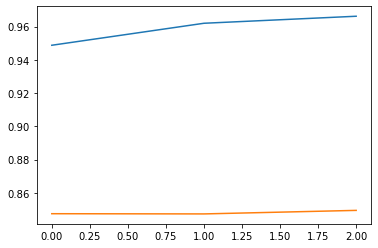

In [35]:
hist = train_history.history
plt.plot(list(range(3)),hist['accuracy'],label='acc')
plt.plot(list(range(3)),hist['val_accuracy'],label='val acc')
plt.legend()
plt.plot()

[]

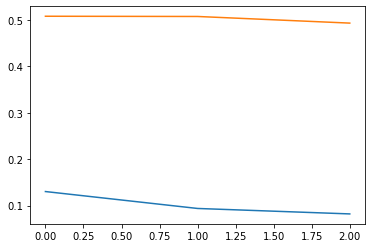

In [36]:
hist = train_history.history
plt.plot(list(range(3)),hist['loss'],label='train loss')
plt.plot(list(range(3)),hist['val_loss'],label='val loss')
plt.legend()
plt.plot()